In [1]:
import foolbox
import torch
import numpy as np
from student_net_learning.models.densenet import densenet201
from foolbox.criteria import TargetClass
from torchvision import transforms
import os
import pandas as pd
from tqdm import tqdm
import scipy.misc
from skimage.measure import compare_ssim


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

args = {
    'root':'../data/imgs/',
    'save_root':'./baseline1/',
    'datalist':'../data/pairs_list.csv',
    'model_name':'DenseNet',
    'checkpoint_path':'./student_net_learning/checkpoint/DenseNet/best_model_chkpt.t7',
    'cuda':'0'
}

pair_imgs_dir='../data/imgs'

torchmodel = densenet201(pretrained=True)
checkpoint = torch.load("./student_net_learning/checkpoint/DenseNet/best_model_chkpt.t7")
torchmodel.load_state_dict(checkpoint['net'])

torchmodel.cuda()

torchmodel.eval()

fmodel = foolbox.models.PyTorchModel(torchmodel, bounds=(0, 1), num_classes=512)

img_pairs = pd.read_csv("../data/pairs_list.csv")

def get_ssim(original_img,changed_img):
    ssim = compare_ssim(np.array(original_img, dtype=np.float32),
                        np.array(changed_img, dtype=np.float32),
                        multichannel=True)
    return ssim

from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClass


torch.Size([32, 512])


torch.Size([32, 512])


In [22]:
# FGSM

from foolbox.criteria import TargetClass

target_class = 22
criterion = TargetClass(target_class)
attack = foolbox.attacks.FGSM(fmodel,target_class)


In [2]:

from foolbox.criteria import TargetClass

target_class = 22
criterion = TargetClass(target_class)
attack=foolbox.attacks.IterativeGradientSignAttack(fmodel, criterion=criterion)

In [3]:

%matplotlib inline 


for idx in tqdm(img_pairs.index.values):
    pair_dict = {'source': img_pairs.loc[idx].source_imgs.split('|'),
                 'target': img_pairs.loc[idx].target_imgs.split('|')}

    source_img=os.path.join(args['root'],pair_dict['source'][0])
    target_img=pair_dict['target'][0]
    original_image=scipy.misc.imread(source_img)
    image = scipy.misc.imresize(original_image, (112, 112)).astype(np.float32)
    image=image.transpose(2,0,1)/255

    label = np.argmax(fmodel.predictions(image))
    adversarial = attack(image, label=label)
    label_after = np.argmax(fmodel.predictions(adversarial))

    print("\nbefore: {}\n after: {}\n ssim: {}".format(label, label_after, get_ssim(image.transpose((1,2,0)),adversarial.transpose(1,2,0))))

    break


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


/usr/local/lib/python3.5/dist-packages/foolbox/attacks/base.py:103: UserWarning: IterativeGradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


TypeError: 'NoneType' object is not subscriptable

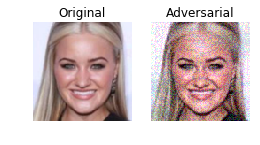

In [24]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image.transpose((1,2,0)))  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

adversarial1=adversarial.transpose((1,2,0))
plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow( adversarial1)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.show()